In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [114]:
INPUTFOLDER = 'C:/Users/Priyanka/Desktop/DataScienceNotebooks/Advanced Machine Learning TRI2/Assignment Kaggle'

item_categories    = pd.read_csv(os.path.join(INPUTFOLDER, 'item_categories.csv'))
items       = pd.read_csv(os.path.join(INPUTFOLDER, 'items.csv'))
shops      = pd.read_csv(os.path.join(INPUTFOLDER, 'shops.csv'))

train       = pd.read_csv(os.path.join(INPUTFOLDER, 'sales_train.csv'))
test        = pd.read_csv(os.path.join(INPUTFOLDER, 'test.csv'))

samples_df     = pd.read_csv(os.path.join(INPUTFOLDER, 'sample_submission.csv'))

In [115]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [116]:
train.shape

(2935849, 6)

In [117]:
Id = test['ID']
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [118]:
test.shape

(214200, 3)

In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [120]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [121]:
correlation_matrix = train.corr().round(2)
correlation_matrix

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.00,0.02,0.01,0.10,0.01
shop_id,0.02,1.00,0.03,-0.02,-0.01
item_id,0.01,0.03,1.00,-0.13,0.02
item_price,0.10,-0.02,-0.13,1.00,0.01
item_cnt_day,0.01,-0.01,0.02,0.01,1.00


<AxesSubplot:>

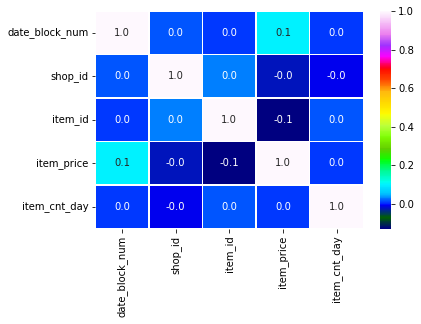

In [122]:
sns.heatmap(correlation_matrix, annot = True, fmt = ".1f", linewidths=.5, cmap='gist_ncar')

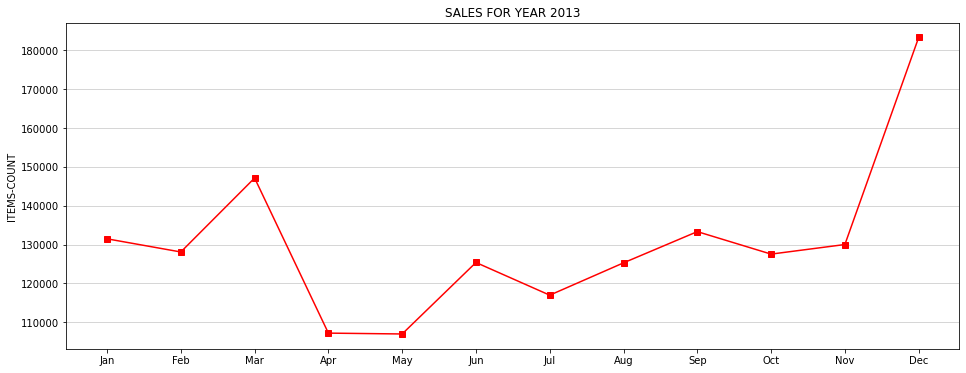

In [123]:
%matplotlib inline
sales_df = train
sales_df["month"]=pd.DatetimeIndex(pd.to_datetime(sales_df['date'],format='%d.%m.%Y')).month
sales_df["year"]=pd.DatetimeIndex(pd.to_datetime(sales_df['date'],format='%d.%m.%Y')).year
sales_df["day"]=pd.DatetimeIndex(pd.to_datetime(sales_df['date'],format='%d.%m.%Y')).day

#Lets Plot the trend of sale for year 2013
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

check_trend = sales_df[['date_block_num','item_cnt_day', 'month','year']].copy()

# Sum of sold items as per date_block_num
check_trend = check_trend.groupby('date_block_num', as_index=False)\
       .agg({'year':'first', 'month':'first', 'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)

plt.figure(figsize=(16,6))
plt.plot(MONTHS, check_trend[check_trend.year==2013].item_cnt_month, '-s', color='Red', label='2013')

# Axes parameters
ax = plt.gca()
ax.set_title('SALES FOR YEAR 2013')
ax.set_ylabel('ITEMS-COUNT')
ax.grid(axis='y', color='black', alpha=.2)

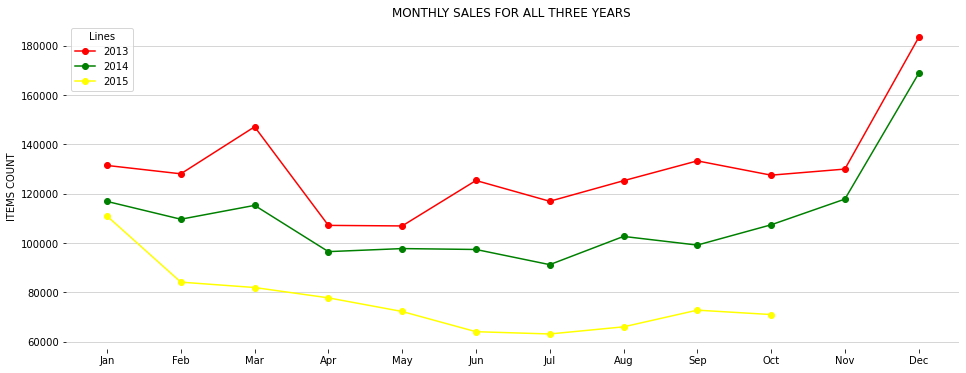

In [124]:
# Same way let's plot for all three years data together to compare the trend

plt.figure(figsize=(16,6))

#2013
plt.plot(MONTHS, check_trend[check_trend.year==2013].item_cnt_month, '-o', color='red', label='2013')

# 2014
plt.plot(MONTHS, check_trend[check_trend.year==2014].item_cnt_month, '-o', color='green', label='2014')

# 2015 - is until October only
plt.plot(MONTHS[:10], check_trend[check_trend.year==2015].item_cnt_month, '-o', color='yellow', label='2015')


# Axes parameters
ax = plt.gca()
ax.set_title('MONTHLY SALES FOR ALL THREE YEARS ')
ax.set_ylabel('ITEMS COUNT')
ax.grid(axis='y', color='black', alpha=.2)
    
# Remove the frame off the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend(loc=2, title='Lines')
plt.show()

<Figure size 864x576 with 0 Axes>

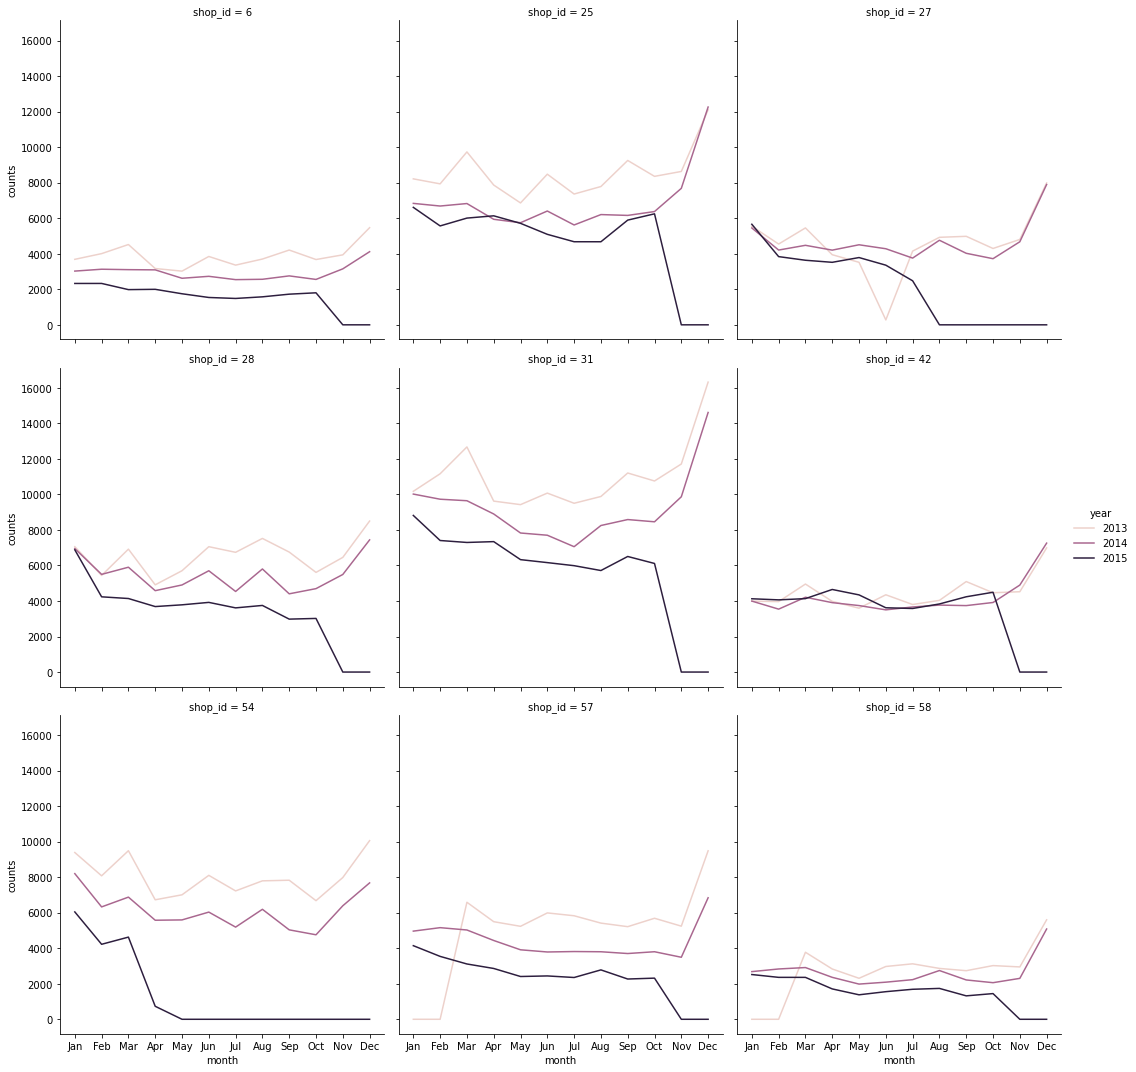

In [125]:
#Lets check what is same data for all years togehter as per shop
%matplotlib inline
shops_counts = pd.DataFrame()
shops_counts['shop_id'] = shops.shop_id
shops_counts['counts'] = [sales_df.item_cnt_day[sales_df.shop_id == x].sum() for x in shops.shop_id]
best_shops = list(shops_counts.sort_values('counts', ascending=False).head(9).shop_id)

counts_input = []
years_input = []
months_input = []
shops_input = []

for y in [2013,2014,2015]:
    for mm, m in zip(range(1, 13), MONTHS):
        for s in best_shops:
            the_input = sales_df.item_cnt_day[(sales_df.year == y) &
                                           (sales_df.month == mm) &
                                           (sales_df.shop_id == s)].sum()
            counts_input.append(the_input)
            years_input.append(y)
            months_input.append(m)
            shops_input.append(s)

df_exm_shops = pd.DataFrame()
df_exm_shops['year'] = years_input
df_exm_shops['month'] = months_input
df_exm_shops['shop_id'] = shops_input
df_exm_shops['counts'] = counts_input

plt.figure(figsize=(12, 8))
sns.relplot(data=df_exm_shops, x='month', y='counts', hue='year',
            col='shop_id', col_wrap=3, kind='line')

In [126]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


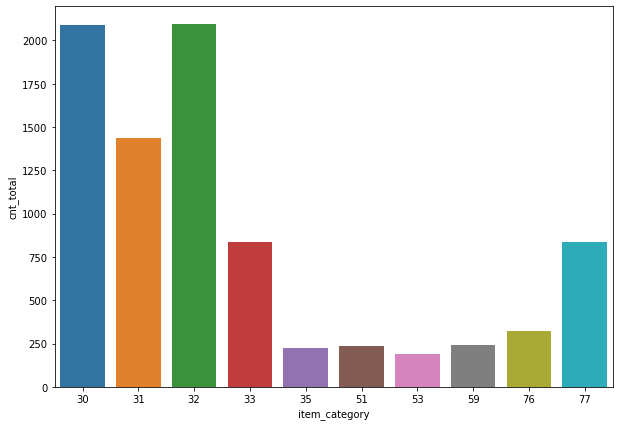

In [127]:
#Lets Also check which Item category is sold most to check the impact of item categories
%matplotlib inline

most_bought = pd.DataFrame()
most_bought['item_category'] = item_categories.item_category_id

bought = []
for i in most_bought['item_category']:
    x = train.item_cnt_day[train.item_id == i].sum()
    bought.append(x)
most_bought['cnt_total'] = bought

most_bought = most_bought.sort_values('cnt_total', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=most_bought.iloc[:10], x='item_category', y='cnt_total')

del most_bought

**Feature Engineering**

In [128]:
# Lets convert the date column to datetime data type
train['date'] = pd.to_datetime(train['date'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,day
0,2013-02-01,0,59,22154,999.00,1.0,1,2013,2
1,2013-03-01,0,25,2552,899.00,1.0,1,2013,3
2,2013-05-01,0,25,2552,899.00,-1.0,1,2013,5
3,2013-06-01,0,25,2554,1709.05,1.0,1,2013,6
4,2013-01-15,0,25,2555,1099.00,1.0,1,2013,15


In [129]:
#Lets keep the month and year
train['date'] = train['date'].apply(lambda x: x.strftime("%Y-%m"))
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,day
0,2013-02,0,59,22154,999.00,1.0,1,2013,2
1,2013-03,0,25,2552,899.00,1.0,1,2013,3
2,2013-05,0,25,2552,899.00,-1.0,1,2013,5
3,2013-06,0,25,2554,1709.05,1.0,1,2013,6
4,2013-01,0,25,2555,1099.00,1.0,1,2013,15


In [130]:
# Sort the vlaues as per Month-Year in ascending order
train.head().sort_values(by = 'date')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,day
4,2013-01,0,25,2555,1099.00,1.0,1,2013,15
0,2013-02,0,59,22154,999.00,1.0,1,2013,2
1,2013-03,0,25,2552,899.00,1.0,1,2013,3
2,2013-05,0,25,2552,899.00,-1.0,1,2013,5
3,2013-06,0,25,2554,1709.05,1.0,1,2013,6


In [131]:
train['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [132]:
# Remove the date_block_num and item_price column
train.drop(['date_block_num','item_price'] , axis =1, inplace= True)

In [133]:
train.head().sort_values(by = 'date')

,date,shop_id,item_id,item_cnt_day,month,year,day
4,2013-01,25,2555,1.0,1,2013,15
0,2013-02,59,22154,1.0,1,2013,2
1,2013-03,25,2552,1.0,1,2013,3
2,2013-05,25,2552,-1.0,1,2013,5
3,2013-06,25,2554,1.0,1,2013,6


#### OUTLIERS check

<AxesSubplot:>

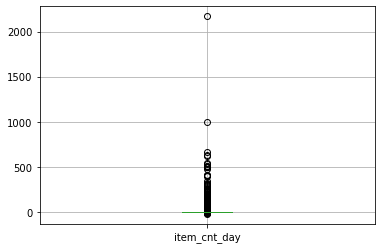

In [134]:
train.boxplot(column=["item_cnt_day"])

<AxesSubplot:>

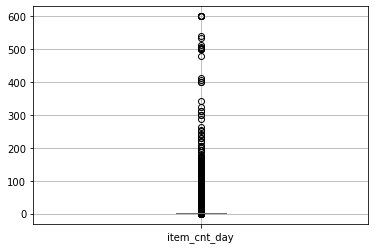

In [135]:
# Remove the outliers

train["item_cnt_day"] = train["item_cnt_day"].clip(-1,600)
train.boxplot(column=["item_cnt_day"])

In [136]:
#create a new data frame grouping as per date , sho_id and item_id
df = train.groupby(['date','shop_id','item_id']).sum()
df

item_cnt_day  month  year  day
date    shop_id item_id                                
2013-01 0       32                4.0      3  6039   77
                33                2.0      2  4026   45
                35                2.0      3  4026   32
                43                1.0      1  2013   31
                51                2.0      2  4026   44
...                               ...    ...   ...  ...
2015-12 59      21421             1.0      5  2015   12
                21669             1.0      1  2015   12
                21872             1.0      6  2015   12
                21968            -1.0      8  2015   12
                22088             2.0      5  2015   12

[1799395 rows x 4 columns]

In [137]:
df = train.pivot_table(index=['shop_id','item_id'], columns='date', values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)
df.head()

date,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,0,30,0.000000,3.444444,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.000000,1.571429,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,1.333333,1.500000,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,1.000000,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.000000,1.200000,0.0,1.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
test_df = pd.merge(test, df, on=['shop_id','item_id'], how='left')
test_df.drop(['ID', '2013-01'], axis=1, inplace=True)
test_df = test_df.fillna(0)
test_df.head()

,shop_id,item_id,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.5,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## MODEL CHECK AND SELCTION

In [139]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [140]:
# Lets devide the data into Train and validation sets
Y = df['2015-10'].values
X = df.drop(['2015-10'], axis = 1)
test_full = test_df

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [142]:
# Check Shapes for the devided for train and test columns should be same
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(339299, 37)
(339299,)
(84825, 37)
(84825,)


#### **1st Model is - Linear Regression**

In [143]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('MSE TRAINING:', mean_squared_error(y_train, lr.predict(X_train)))
print('MSE TESTING:', mean_squared_error(y_test, lr.predict(X_test)))
print('TRAINING SCORE:', lr.score(X_train,y_train))

MSE TRAINING: 0.15862621680004388
MSE TESTING: 0.4304186408873432
TRAINING SCORE: 0.8337276029564844


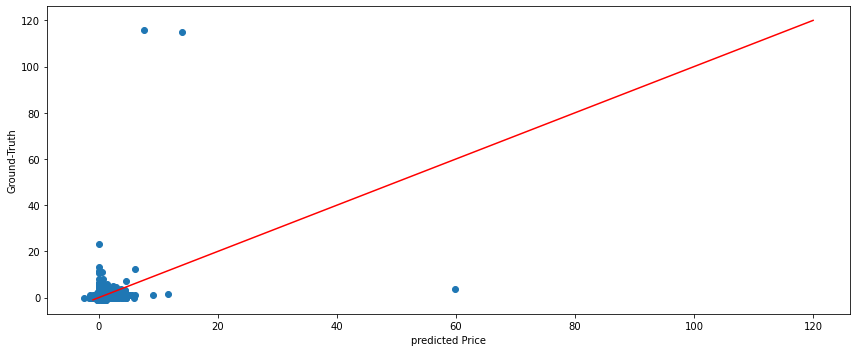

In [144]:
plt.figure(figsize=(12,5))

plt.scatter(lr.predict(X_test),y_test,)
plt.xlabel('predicted Price')
plt.ylabel('Ground-Truth')

plt.plot([-1,120],[-1,120], color = 'red')
plt.tight_layout()

#### To add regularization Lasso- check hypertuning parameter alpha value using GridSearchCV

In [145]:
from sklearn.model_selection import GridSearchCV
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
#grid = GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring='r2', verbose=0, )
#predictionG = grid.fit(X_train, y_train)
#print('Best Score: ', predictionG.best_score_)
#print('Best Params: ', predictionG.best_params_)

#### 2nd We are trying Lasso regularization model on above selected parameters

In [146]:
lso = Lasso(alpha=0.001)
lso.fit(X_train, y_train)
print('MSE TRAINING:', mean_squared_error(y_train, lso.predict(X_train)))
print('MSE TESTING:', mean_squared_error(y_test, lso.predict(X_test)))
print('TRAINING SCORE:', lso.score(X_train,y_train))

MSE TRAINING: 0.15871975642015776
MSE TESTING: 0.430086039936366
TRAINING SCORE: 0.8336295544928154


#### As we saw a great variance in results for Lasso lets check same parameters search for RIDGE

In [147]:
# find optimal alpha with grid search

#grid = GridSearchCV(estimator=Ridge(), param_grid=param_grid, scoring='r2', verbose=0, )
#predictionG = grid.fit(X_train, y_train)
#print('Score: ', predictionG.best_score_)
#print('Parameters: ', predictionG.best_params_)

#### 3rd We are trying Ridge regularization model on above selected parameters

In [148]:
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)
print('MSE TRAINING:', mean_squared_error(y_train, ridge.predict(X_train)))
print('MSE TESTING:', mean_squared_error(y_test, ridge.predict(X_test)))
print('TRAINING SCORE:', ridge.score(X_train,y_train))

MSE TRAINING: 0.15864015838687037
MSE TESTING: 0.43101063834673764
TRAINING SCORE: 0.8337129893503163


#### 4th we are trying Random Forest

In [149]:
forestR = RandomForestRegressor(n_estimators = 102)
forestR.fit(X_train, y_train)
print('MSE TRAINING:', mean_squared_error(y_train, forestR.predict(X_train)))
print('MSE TESTING:', mean_squared_error(y_test, forestR.predict(X_test)))
print('TRAINING SCORE:', forestR.score(X_train,y_train))

MSE TRAINING: 0.09674319935442488
MSE TESTING: 0.36715945316089116
TRAINING SCORE: 0.8985935365615145


#### 5th is GradientBoostingRegressor

In [150]:
grad_boost = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 100, random_state = 42)
grad_boost.fit(X_train, y_train)
print('Train set mse:', mean_squared_error(y_train, grad_boost.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, grad_boost.predict(X_test)))
print('Train set score:', grad_boost.score(X_train,y_train))

Train set mse: 0.09196198804678613
Test set mse: 0.3440590262088181
Train set score: 0.9036052142080587


### 6th is XGB

In [151]:
xgb = XGBRegressor().fit(X_train, y_train)
print('Train set mse:', mean_squared_error(y_train, xgb.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, xgb.predict(X_test)))
print('Train set score:', xgb.score(X_train,y_train))

Train set mse: 0.07728158721645524
Test set mse: 0.39782209195715584
Train set score: 0.9189932470620205


In [152]:
#prediction = xgb.predict(test_full)

In [153]:
#prediction = list(map(round, prediction))

In [154]:
#sample_sub['item_cnt_month'] = prediction
#sample_sub.to_csv('prediction2.csv', index=False)
#sample_sub.head()

In [155]:
#sample_sub['item_cnt_month'].unique()